# Creating a Downsampled Test Dataset

This notebook will create a parquet file of downsampled CUPRAC detected shiraz signals at 450 nm. The database data will be time offset and precision corrected and set to a universal time index. The wine column level will have duplicates made unique via the addition of an ascending integer.


In [57]:
%load_ext autoreload
%autoreload 2

from wine_analysis_hplc_uv import definitions
from wine_analysis_hplc_uv.signal_processing.mindex_signal_processing import SignalProcessor
import pandas as pd
import numpy as np
sigpro = SignalProcessor()
df = pd.read_parquet(definitions.RAW_PARQ_PATH)
df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


samplecode                                   154            \
wine       2020 leeuwin estate shiraz art series             
vars                                        mins     value   
i                                                            
0                                       0.002500  2.260849   
1                                       0.009167  2.960749   
2                                       0.015833  3.189206   
3                                       0.022500  3.115371   
4                                       0.029167  2.675273   
...                                          ...       ...   
5995                                   39.969167  5.433515   
5996                                   39.975833  5.405843   
5997                                   39.982500  5.397283   
5998                                   39.989167  5.404085   
5999                                   39.995833  5.438834   

samplecode                                   176            \
wine       2021 john duval wines shiraz concilio             
vars                                        mins     value   
i                                                            
0                                       0.006450  2.392285   
1                                       0.013117  2.801619   
2                                       0.019783  2.718344   
3                                       0.026450  2.283610   
4                                       0.033117  1.402728   
...                                          ...       ...   
5995                                   39.973117 -0.689976   
5996                                   39.979783 -0.674434   
5997                                   39.986450 -0.676699   
5998                                   39.993117 -0.704534   
5999                                   39.999783 -0.749595   

samplecode                             177            \
wine       2021 torbreck shiraz the struie             
vars                                  mins     value   
i                                                      
0                                 0.006667  1.575358   
1                                 0.013333  1.721062   
2                                 0.020000  1.598060   
3                                 0.026667  1.263864   
4                                 0.033333  0.653356   
...                                    ...       ...   
5995                             39.973333  0.097781   
5996                             39.980000  0.112072   
5997                             39.986667  0.112422   
5998                             39.993333  0.090495   
5999                             40.000000  0.054680   

samplecode                 torbreck-struie            
wine       2021 torbreck shiraz the struie            
vars                                  mins     value  
i                                                     
0                                 0.005617  4.086323  
1                                 0.012283  5.644433  
2                                 0.018950  6.435014  
3                                 0.025617  6.426491  
4                                 0.032283  5.574182  
...                                    ...       ...  
5995                                   NaN       NaN  
5996                                   NaN       NaN  
5997                                   NaN       NaN  
5998                                   NaN       NaN  
5999                                   NaN       NaN  

[6000 rows x 8 columns]

## Downsampling

Apply the methods pioneerd in [time_axis_characterisation_and_normalization](notebooks/time_axis_characterisation_and_normalization.ipynb) and [downsampling_signals](notebooks/downsampling_signals.ipynb) to move the dataset to a global time index then downsample to 2 seconds per observation.

In [58]:
df = \
(
    df.pipe(sigpro.standardize_time)
    .resample("2S")
    .interpolate()
)
df

samplecode,154,176,177,torbreck-struie
wine,2020 leeuwin estate shiraz art series,2021 john duval wines shiraz concilio,2021 torbreck shiraz the struie,2021 torbreck shiraz the struie
vars,value,value,value,value
mins,,,,
0 days 00:00:00,2.260849,2.392285,1.575358,4.086323
0 days 00:00:02,1.783684,0.244185,-0.086561,3.921792
0 days 00:00:04,-0.335634,-0.764884,-0.488006,-1.053140
0 days 00:00:06,-0.030212,-0.346735,-0.239164,-0.608116
0 days 00:00:08,-0.015639,-0.301532,-0.127859,-0.548452
...,...,...,...,...
0 days 00:39:50,5.454086,-0.783697,0.010632,1.699664


## Subsetting

As discussed in [downsampling_signals](notebooks/downsampling_signals.ipynb), the area of interest is 0 - 20 mins. I will first reduce this test dataset to that range:

In [59]:
df = (df
 .loc[:pd.to_timedelta(20,unit='min')]
 )
df

samplecode,154,176,177,torbreck-struie
wine,2020 leeuwin estate shiraz art series,2021 john duval wines shiraz concilio,2021 torbreck shiraz the struie,2021 torbreck shiraz the struie
vars,value,value,value,value
mins,,,,
0 days 00:00:00,2.260849,2.392285,1.575358,4.086323
0 days 00:00:02,1.783684,0.244185,-0.086561,3.921792
0 days 00:00:04,-0.335634,-0.764884,-0.488006,-1.053140
0 days 00:00:06,-0.030212,-0.346735,-0.239164,-0.608116
0 days 00:00:08,-0.015639,-0.301532,-0.127859,-0.548452
...,...,...,...,...
0 days 00:19:52,8.010603,14.017858,16.811155,28.317384


## Making 'wine' Unique

While not strictly necessary, for visualisation purposes, it is useful to have 1 column that is both the primary key and label. Currently I have two identically labelled 'torbreck the struie' wines, which means I either use the samplecode column, which is not relatable, or I make the wine column unique. I have gone with the latter.

In [60]:
"""
Form label dataframe from multiindex, form label column as concat of wine + cumcount+1.
Join with label column on samplecode index, use label column to map to wine, fill it
where NA with wine value (i.e. unique wine names) then replace wine column with label
through assign.
"""
# add the label as a concatentation of cumcount+1 and wine name
labels = (df
.columns
.to_frame()
.reset_index(drop=True)
[['samplecode','wine']]
.set_index('samplecode')
[lambda df: df.duplicated(keep=False)]
.assign(label=lambda df: df['wine'] + " " + df.groupby(['wine']).cumcount().add(1).astype(str))
)

# go to long format, join with label df on samplecode, merge label and wine column via
# where, replace wine column with the merge, go back to tidy format
df = (df
 .stack(['samplecode','wine'])
 .reset_index('mins')
 .join(labels['label'])
 .rename_axis('vars',axis=1)
 .reset_index()
 .pipe(lambda df:
     df.assign(wine=df['label'].where(~df['label'].isna(),df['wine']))
     )
 .drop(['label'],axis=1)
 .set_index(['samplecode','wine','mins'])
 .unstack(['samplecode','wine'])
 .reorder_levels(axis=1, order=['samplecode','wine','vars'])
 .sort_index(axis=1, level='samplecode')
)
df

samplecode,154,176,177,torbreck-struie
wine,2020 leeuwin estate shiraz art series,2021 john duval wines shiraz concilio,2021 torbreck shiraz the struie 1,2021 torbreck shiraz the struie 2
vars,value,value,value,value
mins,,,,
0 days 00:00:00,2.260849,2.392285,1.575358,4.086323
0 days 00:00:02,1.783684,0.244185,-0.086561,3.921792
0 days 00:00:04,-0.335634,-0.764884,-0.488006,-1.053140
0 days 00:00:06,-0.030212,-0.346735,-0.239164,-0.608116
0 days 00:00:08,-0.015639,-0.301532,-0.127859,-0.548452
...,...,...,...,...
0 days 00:19:52,8.010603,14.017858,16.811155,28.317384


## Outcome

Below is a plot of the processed and downsampled dataset:

,samplecode,wine,vars,value
mins,,,,
0 days 00:00:00,154,2020 leeuwin estate shiraz art series,value,2.260849
0 days 00:00:02,154,2020 leeuwin estate shiraz art series,value,1.783684
0 days 00:00:04,154,2020 leeuwin estate shiraz art series,value,-0.335634
0 days 00:00:06,154,2020 leeuwin estate shiraz art series,value,-0.030212
0 days 00:00:08,154,2020 leeuwin estate shiraz art series,value,-0.015639
...,...,...,...,...
0 days 00:19:52,torbreck-struie,2021 torbreck shiraz the struie 2,value,28.317384
0 days 00:19:54,torbreck-struie,2021 torbreck shiraz the struie 2,value,27.064987
0 days 00:19:56,torbreck-struie,2021 torbreck shiraz the struie 2,value,26.246436


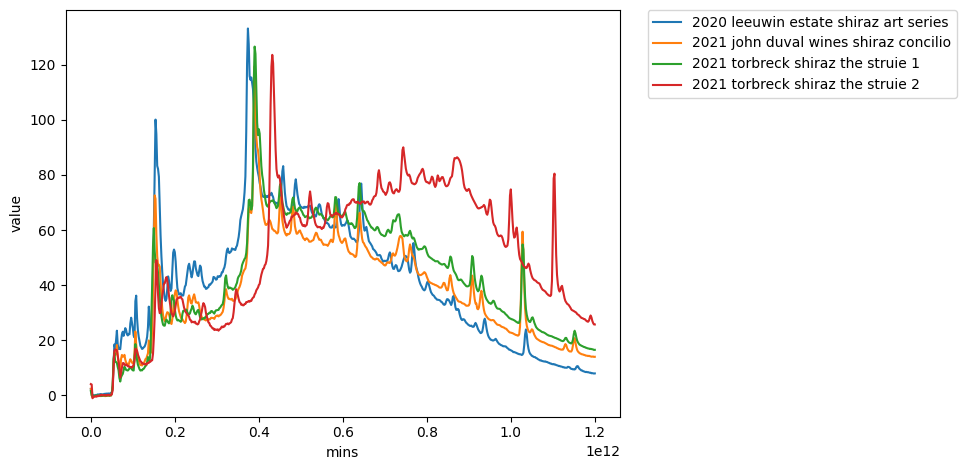

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1)

(
    df
    # .reset_index()
    .melt(ignore_index=False)
    .pipe(lambda df: df if display(df) else df) # display df
    .pipe(lambda df: sns.lineplot(df, ax=ax,x='mins',y='value',hue='wine'))
);
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

## Write to File

Testing between read times for parquet and csv found that parquet read times were twice as fast. so use parquet.

In [62]:
from wine_analysis_hplc_uv import definitions
df.to_parquet(
    definitions.XPRO_DOWNSAMPLED_PARQ_PATH
)

In [63]:
a = pd.read_parquet(
    definitions.XPRO_DOWNSAMPLED_PARQ_PATH
)
a

samplecode,154,176,177,torbreck-struie
wine,2020 leeuwin estate shiraz art series,2021 john duval wines shiraz concilio,2021 torbreck shiraz the struie 1,2021 torbreck shiraz the struie 2
vars,value,value,value,value
mins,,,,
0 days 00:00:00,2.260849,2.392285,1.575358,4.086323
0 days 00:00:02,1.783684,0.244185,-0.086561,3.921792
0 days 00:00:04,-0.335634,-0.764884,-0.488006,-1.053140
0 days 00:00:06,-0.030212,-0.346735,-0.239164,-0.608116
0 days 00:00:08,-0.015639,-0.301532,-0.127859,-0.548452
...,...,...,...,...
0 days 00:19:52,8.010603,14.017858,16.811155,28.317384
